In [3]:
%matplotlib inline
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt
import pyro.optim as optim
import pyro.distributions as dist
from torch.distributions import constraints
from tqdm import tqdm_notebook as tqdm  
import seaborn as sns
from matplotlib import animation, rc
from IPython.display import HTML
import torch.nn as nn
from functools import partial
import pandas as pd
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoDelta
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive
import pandas as pd

from pyro import poutine

In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable

from numpy import pi
import numpy as np


In [5]:
pyro.set_rng_seed(1)
pyro.enable_validation(True)
torch.set_default_dtype(torch.float64)

In [6]:
def load(file_name, delete_columns=None, y_column=-1):
    if delete_columns is None:
        delete_columns = []
    df = pd.read_csv(file_name, header=None)
    matrix = df.to_numpy()
    result_matrix = np.delete(matrix, delete_columns, axis=1)
    result_matrix = np.delete(result_matrix, y_column, axis=1)
    result_matrix = np.hstack((result_matrix, matrix[:, y_column][:, np.newaxis]))
    return result_matrix


def split_data(raw_data_matrix, test_set_percent, shuffle):
    if shuffle:
        process_data = np.random.permutation(raw_data_matrix)
    else:
        process_data = raw_data_matrix
    split_index = int(process_data.shape[0] * test_set_percent)
    return process_data[:split_index, :], process_data[split_index:, :]


def extract_attributes_label(data_matrix) -> dict:
    class_vector, class_labels = pd.factorize(data_matrix[:, -1])
    data_matrix = np.vstack((data_matrix[:, :-1].T, class_vector)).T.astype(float)
    return {"x_y": data_matrix, "x": data_matrix[:, :-1], "y": data_matrix[:, -1], "y_labels": np.vstack(
        (np.arange(class_labels.size), class_labels)).T, "y_values": np.arange(class_labels.size)}


def positive(predict_vector, class_vector):
    return np.count_nonzero((predict_vector - class_vector) == 0) / predict_vector.shape[0]

def calc_metric(y_true: np.ndarray, y_pred: np.ndarray, average: str = "macro"):
    return Metric(
        accuracy=sm.accuracy_score(y_true, y_pred),
        precision=sm.precision_score(y_true, y_pred, average=average),
        recall=sm.recall_score(y_true, y_pred, average=average),
        f1=sm.f1_score(y_true, y_pred, average=average)
    )

In [7]:
data_matrix = (load("data/iris.csv"), "iris")
extracted_data = extract_attributes_label(data_matrix[0])

x_data = torch.from_numpy(extracted_data["x"])
y_data = torch.from_numpy(extracted_data["y"])
classes_nbr = len(y_data.unique())
features_nbr = len(x_data[1,:])
count = len(y_data)



In [8]:
class NBModel(nn.Module):
    def __init__(self,classes,features):
        super(self.__class__, self).__init__()
        self.classes = classes
        self.features = features
        
        self.register_parameter(
            "means",
            nn.Parameter(torch.zeros(self.classes, self.features))
        )
        self.register_parameter(
            "variances",
            nn.Parameter(torch.ones(self.classes, self.features))
        )
        self.register_parameter(
            "classes_priors",
            nn.Parameter(torch.ones(self.classes) * (1/self.classes))
        )

    def forward(self, x):
        x = x[:,np.newaxis,:]
        return (torch.sum(- 0.5 * torch.log(2. * pi * self.variances)
                - (x - self.means)**2 / torch.abs(self.variances) / 2, dim=-1)
                + torch.log(self.classes_priors))
    
nbModel = NBModel(classes_nbr,features_nbr)

In [9]:
def nb_model2(x_data, y_data):
    means = pyro.distributions.Normal(loc=torch.zeros_like(nbModel.means), scale=torch.ones_like(nbModel.means)).to_event(2)
    variances = pyro.distributions.InverseGamma(concentration=torch.ones_like(nbModel.variances),rate=torch.ones_like(nbModel.variances)).to_event(2)
    classes_priors = pyro.distributions.Dirichlet(concentration=torch.ones_like(nbModel.classes_priors))
    
    priors = {'means': means, 'variances': variances, "classes_priors": classes_priors}
    lifted_module = pyro.random_module("module", nbModel, priors)
    lifted_nb_model = lifted_module()
    
    with pyro.plate("map", len(x_data)):
        class_prob = lifted_nb_model(x_data)
        pyro.sample("obs",pyro.distributions.Categorical(logits=class_prob),obs=y_data)
        pyro.sample("obs_cl",pyro.distributions.Categorical(probs=lifted_nb_model.classes_priors),obs=y_data)
        return class_prob

In [12]:
def train(params):
    step_data = { "loss":[] }
    for param in  params:
        step_data[param]=[]
    pyro.clear_param_store()
    num_iterations=10_000
    model = nb_model2
    guide = AutoDiagonalNormal(model)
    optim = pyro.optim.Adam({"lr": 0.02})
    svi = pyro.infer.SVI(model, guide, optim, loss=pyro.infer.Trace_ELBO(), num_samples=count)
    for j in tqdm(range(num_iterations)):
        loss = svi.step(x_data, y_data.squeeze(-1))
        step_data["loss"].append(loss)
        for param in params:
            step_data[param].append(pyro.param(param).clone())
        if j%1000 == 0:
            print(f"{j}:{loss}")
    return (model, svi, step_data)

In [13]:
probabilistic_model, svi, data = train(("auto_loc","auto_scale"))

0:3428.957076271126
1000:279.2221699685204
2000:232.88936761872478
3000:219.01296492542778
4000:223.51751158486528
5000:219.05400795516474
6000:217.5643589727842
7000:221.13366366279956
8000:217.1954304149483
9000:217.3801970948586



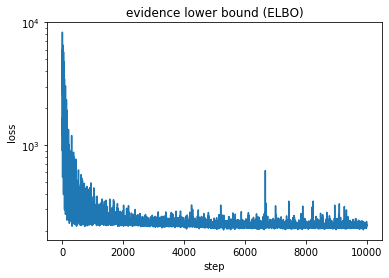

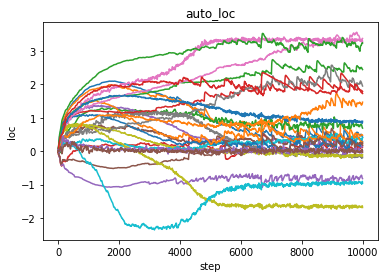

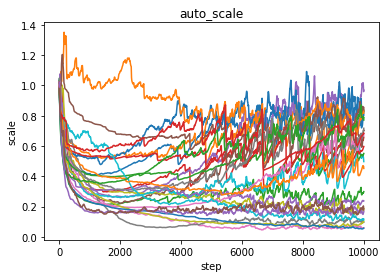

In [18]:
plt.plot(data["loss"])
plt.title("evidence lower bound (ELBO)")
plt.xlabel("step")
plt.yscale("log")
plt.ylabel("loss")
plt.show()
plt.plot([data.detach().numpy() for data in data["auto_loc"]])
plt.title("auto_loc")
plt.xlabel("step")
plt.ylabel("loc")
plt.show()
plt.plot([data.detach().numpy() for data in data["auto_scale"]])
plt.title("auto_scale")
plt.xlabel("step")
plt.ylabel("scale");

In [19]:
def wrapped_model(x_data, y_data):
    model_result=probabilistic_model(x_data, y_data)
    pyro.sample("prediction", pyro.distributions.Delta(model_result))
    
posterior = svi.run(x_data, y_data)

trace_pred = TracePredictive(wrapped_model,
                             posterior,
                             num_samples=1)

In [20]:
post_pred = trace_pred.run(x_data, None)

In [21]:
em = EmpiricalMarginal(post_pred,["prediction"])
prob = em._get_samples_and_weights()[0].detach().cpu().numpy()
prob = np.squeeze(prob)

In [22]:
result = np.argmax(prob,axis=1)

In [23]:
positive(result,y_data.numpy())

0.98

In [24]:
result

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [25]:
y_data.numpy()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

In [27]:
em2=EmpiricalMarginal(post_pred,["module$$$classes_priors"])
prob2 = np.squeeze(em2._get_samples_and_weights()[0].detach().cpu().numpy())

In [28]:
prob2

array([0.29443551, 0.35203023, 0.35353425])

In [31]:
import numpy
actual = y_data.numpy()
predicted = result
import pandas as pd
y_actu = pd.Series(actual, name='Actual')
y_pred = pd.Series(predicted, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)

In [32]:
df_confusion

Predicted,0,1,2
Actual,,,
0.0,50,0,0
1.0,0,48,2
2.0,0,1,49
